In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import traci
import random
import graphviz 
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report
from pandas_profiling import ProfileReport
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [2]:
csv_files = [file for file in os.listdir("/Data") if file.endswith(".csv")]

aggregated_data = pd.DataFrame()

for file in csv_files:
    print(file)
    data = pd.read_csv(file, dtype={'edgeID': str,'occupancy': float, 'meanSpeed': float, 'vehicleCount': float, 'noise': float}, sep = ',')
    aggregated_data = pd.concat([aggregated_data, data], ignore_index=True)

all_anomalies_normal1.csv
all_anomalies_normal2.csv
all_anomalies_rush.csv
all_anomalies_rush2.csv
anomaly_free_normal.csv
anomaly_free_normal2.csv
anomaly_free_rush.csv
anomaly_free_rush2.csv
garbage_light_normal.csv
garbage_light_rush.csv
garbage_normal.csv
garbage_rush.csv
garbage_stop_normal.csv
garbage_stop_rush.csv
light_normal.csv
light_rush.csv
light_stop_normal.csv
light_stop_rush.csv
stop_normal.csv
stop_rush.csv
weather_all_anomalies2_rush.csv
weather_all_anomalies_normal.csv
weather_anomaly_free_normal.csv
weather_anomaly_free_rush.csv


In [4]:
aggregated_data.head()

,step,edgeID,occupancy,meanSpeed,vehicleCount,noise
0,1,-E0,0.0,13.89,0.0,3.0103
1,1,-E13,0.0,13.89,0.0,3.0103
2,1,-E16,0.0,13.89,0.0,0.0000
3,1,-E17,0.0,13.89,0.0,3.0103
4,1,-E2,0.0,13.89,0.0,3.0103


In [102]:
print(len(aggregated_data))

7862400


In [6]:
count_of_X = (aggregated_data['meanSpeed'] == 13.89).sum()
print(count_of_X)

3506738


In [410]:
count_of_maxoccupancy = (aggregated_data['occupancy'] > 0.9).sum()
print(count_of_maxoccupancy / len(aggregated_data) *100)

0.9547339234839235


In [3]:
from pandas_profiling import ProfileReport

aggregated_data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
average_occupancy_by_edge = aggregated_data.groupby('edgeID')['occupancy'].mean()
print(average_occupancy_by_edge.sort_values(ascending=False))

edgeID
-E37    0.487747
E44     0.379383
-E21    0.360277
-E6     0.359760
E25     0.349199
          ...   
E6      0.010432
E8      0.006949
E34     0.006075
-E53    0.004145
E12     0.003868
Name: occupancy, Length: 91, dtype: float64


In [200]:
def classify_congestion_multiclass(x):
    if x <= 0.3:
        return "Not congested"
    elif 0.3 < x <= 0.7: #
        return "Congested"
    else:
        return "Highly congested"

In [180]:
def classify_congestion_binary(x):
    if x <= 0.3:
        return "Not congested"
    else:
        return "Congested"

In [181]:
# üres útszakaszokon sebesség értékek korrigálása
preprocessed_data = aggregated_data.copy(deep=True)
preprocessed_data.loc[(preprocessed_data['meanSpeed'] == 13.890) & (preprocessed_data['vehicleCount'] == 0), 'meanSpeed'] = 20
preprocessed_data = preprocessed_data.drop(columns = ['edgeID', 'step'])

In [182]:
# Bináris klasszifikáció
binary_labeled_data = preprocessed_data.copy(deep=True)
binary_labeled_data['congestion'] = binary_labeled_data['occupancy'].apply(classify_congestion_binary)
binary_labeled_data = binary_labeled_data.drop(columns = ['occupancy'])

In [183]:
print("Congested:", (binary_labeled_data['congestion'] == "Congested").sum())
print("Not congested:", (binary_labeled_data['congestion'] == "Not congested").sum())
print("Az adathalmaz ~%.3f%%-a torlódott" % (100*(binary_labeled_data['congestion'] == "Congested").sum()/len(binary_labeled_data)))

Congested: 1196473
Not congested: 6665927
Az adathalmaz ~15.218%-a torlódott


In [201]:
# Multiclass klasszifikáció
multi_labeled_data = preprocessed_data.copy(deep=True)
multi_labeled_data['congestion'] = multi_labeled_data['occupancy'].apply(classify_congestion_multiclass)
multi_labeled_data = multi_labeled_data.drop(columns = ['occupancy'])

In [202]:
print("Highly congested:", (multi_labeled_data['congestion'] == "Highly congested").sum())
print("Congested:", (multi_labeled_data['congestion'] == "Congested").sum())
print("Not congested:", (multi_labeled_data['congestion'] == "Not congested").sum())
print("Az adathalmaz ~%.3f%%-a torlódott, ~%.3f%%-a pedig erősen torlódott" % (100*(multi_labeled_data['congestion'] == "Congested").sum()/len(multi_labeled_data), 100*(multi_labeled_data['congestion'] == "Highly congested").sum()/len(multi_labeled_data)))

Highly congested: 334391
Congested: 862082
Not congested: 6665927
Az adathalmaz ~10.965%-a torlódott, ~4.253%-a pedig erősen torlódott


In [203]:
def splitting_data(data):
    return train_test_split(data.iloc[:,:-1], data['congestion'], stratify=data['congestion'], random_state=40, test_size=0.33)

In [204]:
Split_all = splitting_data(binary_labeled_data)

In [205]:
no_noise_data = binary_labeled_data.drop(columns = ['noise'])
Split_without_noise = splitting_data(no_noise_data)

In [206]:
onlyspeed_data = binary_labeled_data.drop(columns = ['vehicleCount', 'noise'])
Split_speed = splitting_data(onlyspeed_data)

In [207]:
multiclass_all = splitting_data(multi_labeled_data)

In [208]:
multi_no_noise = multi_labeled_data.drop(columns = ['noise'])
multiclass_without_noise = splitting_data(multi_no_noise)

In [209]:
multi_onlyspeed = multi_labeled_data.drop(columns = ['vehicleCount', 'noise'])
multiclass_speed = splitting_data(multi_onlyspeed)

In [20]:
binary_labeled_data.head()

,meanSpeed,vehicleCount,noise,congestion
0,20.0,0.0,3.0103,Not congested
1,20.0,0.0,3.0103,Not congested
2,20.0,0.0,0.0000,Not congested
3,20.0,0.0,3.0103,Not congested
4,20.0,0.0,3.0103,Not congested


In [431]:
def draw_confusionMatrix(predicted_labels, true_labels, title, binary):
    
    if binary:
        labels = ['Torlódott','Nem torlódott']
        size = (3, 3)
    else:
        labels =  ['Torlódott', 'Erősen torlódott', 'Nem torlódott']
        size = (4, 4)
        
    cm = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=size)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xticks(fontsize=8, rotation='horizontal')
    plt.yticks(fontsize=8, rotation='vertical')
    plt.xlabel('Valós címkék', fontsize= 10)
    plt.ylabel('Előrejelzett címkék', fontsize= 10)
    plt.title(title, fontsize= 11)
    plt.show()

# Decision tree

#### All features (Mean speed + Vehicle count + noise)

Multiclass classification

In [211]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=0.0025, max_depth=12) # min_samples_leaf=0.0025, max_depth=15
clf = clf.fit(multiclass_all[0], multiclass_all[2])

In [212]:
# VehicleCount + MeanSpeed + noise
Tree_multi_all_pred = clf.predict(multiclass_all[1])

In [213]:
print(classification_report(multiclass_all[3], Tree_multi_all_pred))

                  precision    recall  f1-score   support

       Congested       0.73      0.61      0.66    284487
Highly congested       0.62      0.45      0.52    110349
   Not congested       0.94      0.98      0.96   2199756

        accuracy                           0.91   2594592
       macro avg       0.76      0.68      0.72   2594592
    weighted avg       0.91      0.91      0.91   2594592



In [214]:
print("F-1 Score:", f1_score(multiclass_all[3], Tree_multi_all_pred, average='macro'))

F-1 Score: 0.7158938125941177


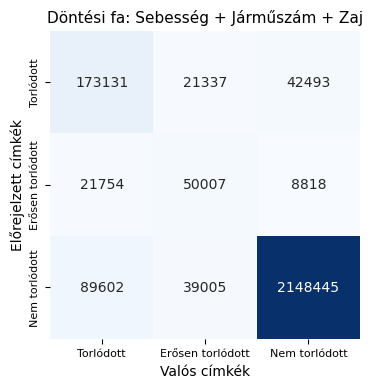

In [415]:
draw_confusionMatrix(multiclass_all[3], Tree_multi_all_pred, "Döntési fa: Sebesség + Járműszám + Zaj", False)

Binary classification

In [216]:
# entropy
clf_binary = tree.DecisionTreeClassifier(min_samples_leaf=0.0025, criterion='entropy') # min_samples_leaf=0.0025, max_depth=15
clf_binary = clf_binary.fit(Split_all[0], Split_all[2])

In [217]:
# Bináris klasszifikáció + minden feature   
Tree_binary_all_pred = clf_binary.predict(Split_all[1])
print(classification_report(Split_all[3], Tree_binary_all_pred))

               precision    recall  f1-score   support

    Congested       0.85      0.68      0.75    394836
Not congested       0.94      0.98      0.96   2199756

     accuracy                           0.93   2594592
    macro avg       0.90      0.83      0.86   2594592
 weighted avg       0.93      0.93      0.93   2594592



In [218]:
print("F-1 Score:", f1_score(Split_all[3], Tree_binary_all_pred, average='macro'))

F-1 Score: 0.8558091393354955


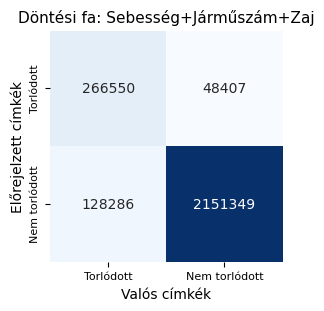

In [416]:
draw_confusionMatrix(Split_all[3], Tree_binary_all_pred, "Döntési fa: Sebesség+Járműszám+Zaj", True)

#### Vehicle count + Mean speed (without noise)

Multiclass classification

In [224]:
clf3 = tree.DecisionTreeClassifier(min_samples_leaf=0.0025) # min_samples_leaf=0.0025, max_depth=15
clf3 = clf3.fit(multiclass_without_noise[0], multiclass_without_noise[2])

In [225]:
Tree_noise_prediction = clf3.predict(multiclass_without_noise[1])
print(classification_report(multiclass_without_noise[3], Tree_noise_prediction))

                  precision    recall  f1-score   support

       Congested       0.73      0.60      0.66    284487
Highly congested       0.61      0.48      0.54    110349
   Not congested       0.94      0.98      0.96   2199756

        accuracy                           0.91   2594592
       macro avg       0.76      0.68      0.72   2594592
    weighted avg       0.91      0.91      0.91   2594592



In [226]:
print("F-1 Score:", f1_score(multiclass_without_noise[3], Tree_noise_prediction, average='macro'))

F-1 Score: 0.7171046337667298


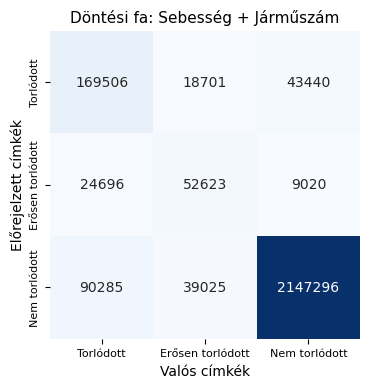

In [417]:
draw_confusionMatrix(multiclass_without_noise[3], Tree_noise_prediction, "Döntési fa: Sebesség + Járműszám", False)

Binary classification

In [228]:
tree_noise = tree.DecisionTreeClassifier(min_samples_leaf=0.0025, criterion='entropy') # min_samples_leaf=0.0025, max_depth=15
tree_noise = tree_noise.fit(Split_without_noise[0], Split_without_noise[2])

In [229]:
tree_binary_noise_prediction = tree_noise.predict(Split_without_noise[1])
print(classification_report(Split_without_noise[3], tree_binary_noise_prediction))

               precision    recall  f1-score   support

    Congested       0.83      0.68      0.75    394836
Not congested       0.94      0.97      0.96   2199756

     accuracy                           0.93   2594592
    macro avg       0.89      0.83      0.85   2594592
 weighted avg       0.93      0.93      0.93   2594592



In [230]:
print("F-1 Score:", f1_score(Split_speed[3], tree_binary_noise_prediction, average='macro'))

F-1 Score: 0.8545030687904485


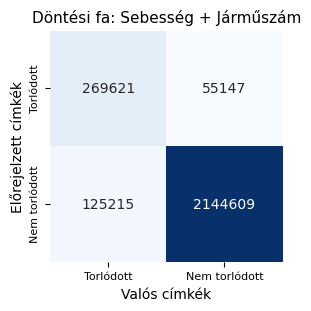

In [418]:
draw_confusionMatrix(Split_without_noise[3], tree_binary_noise_prediction, "Döntési fa: Sebesség + Járműszám", True)

#### Only Mean speed used as feature

Multiclass classification

In [233]:
clf2 = tree.DecisionTreeClassifier(min_samples_leaf=0.0025) # min_samples_leaf=0.0025, max_depth=15
clf2 = clf2.fit(multiclass_speed[0], multiclass_speed[2])

In [234]:
Tree_speed_prediction = clf2.predict(multiclass_speed[1])
print(classification_report(multiclass_speed[3], Tree_speed_prediction))

                  precision    recall  f1-score   support

       Congested       0.59      0.53      0.56    284487
Highly congested       0.39      0.63      0.48    110349
   Not congested       0.96      0.94      0.95   2199756

        accuracy                           0.88   2594592
       macro avg       0.65      0.70      0.66   2594592
    weighted avg       0.89      0.88      0.89   2594592



In [235]:
print("F-1 Score:", f1_score(multiclass_speed[3], Tree_speed_prediction, average='macro'))

F-1 Score: 0.6629266566585058


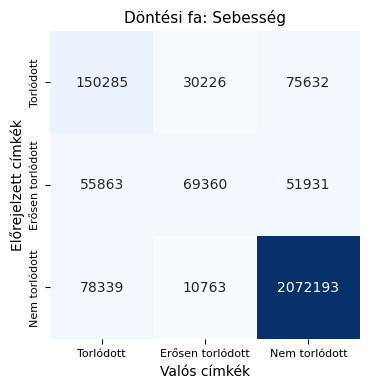

In [419]:
draw_confusionMatrix(multiclass_speed[3], Tree_speed_prediction, "Döntési fa: Sebesség", False)

Binary classification

In [237]:
tree_speed = tree.DecisionTreeClassifier(min_samples_leaf=0.0025, criterion='entropy') # min_samples_leaf=0.0025, max_depth=15
tree_speed = tree_speed.fit(Split_speed[0], Split_speed[2])

In [238]:
tree_binary_speed_prediction = tree_speed.predict(Split_speed[1])
print(classification_report(Split_speed[3], tree_binary_speed_prediction))

               precision    recall  f1-score   support

    Congested       0.71      0.77      0.74    394836
Not congested       0.96      0.94      0.95   2199756

     accuracy                           0.92   2594592
    macro avg       0.83      0.86      0.84   2594592
 weighted avg       0.92      0.92      0.92   2594592



In [239]:
print("F-1 Score:", f1_score(Split_speed[3], tree_binary_speed_prediction, average='macro'))

F-1 Score: 0.8445435290854606


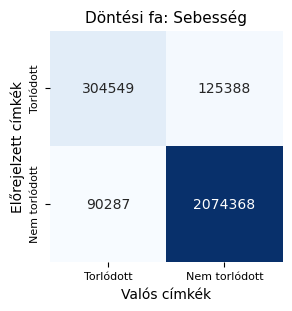

In [420]:
draw_confusionMatrix(Split_speed[3], tree_binary_speed_prediction, "Döntési fa: Sebesség", True)

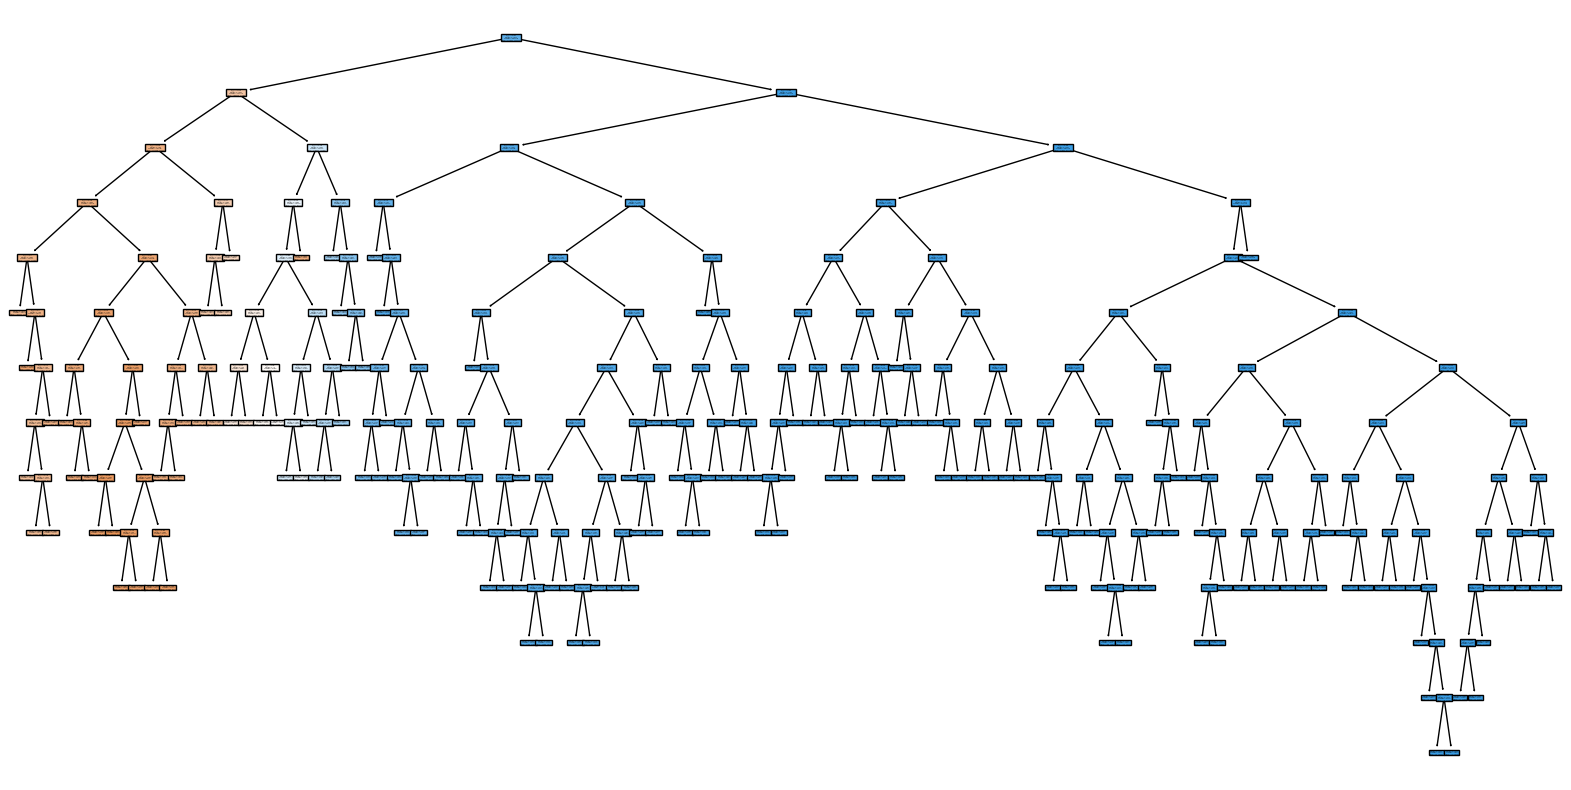

In [47]:
#tree.plot_tree(clf)
#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("tree")

plt.figure(figsize=(20, 10))
plot_tree(tree_speed, filled=True)
plt.show()

# Logistic regression

Binary classification

#### All features (Mean speed + Vehicle count + noise)

In [296]:
regression_all = LogisticRegression()
regression_all.fit(Split_all[0], Split_all[2])

LogisticRegression()

In [297]:
Regression_all_pred = regression_all.predict(Split_all[1])

In [298]:
print(classification_report(Split_all[3], Regression_all_pred))

               precision    recall  f1-score   support

    Congested       0.73      0.78      0.75    394836
Not congested       0.96      0.95      0.95   2199756

     accuracy                           0.92   2594592
    macro avg       0.85      0.86      0.85   2594592
 weighted avg       0.93      0.92      0.92   2594592



In [299]:
print("F-1 Score:", f1_score(Split_all[3], Regression_all_pred, average='macro'))

F-1 Score: 0.8544853897201161


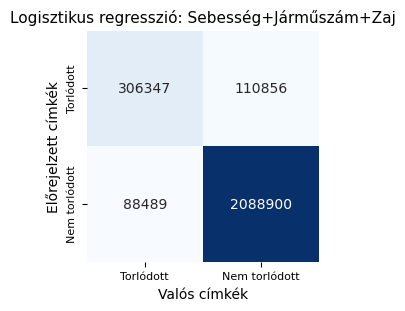

In [421]:
draw_confusionMatrix(Split_all[3], Regression_all_pred, "Logisztikus regresszió: Sebesség+Járműszám+Zaj", True)

#### Vehicle count + Mean speed (without noise)

In [301]:
regression_noise_binary = LogisticRegression()
regression_noise_binary.fit(Split_without_noise[0], Split_without_noise[2])

LogisticRegression()

In [302]:
regression_binary_noise_prediction = regression_noise_binary.predict(Split_without_noise[1])
print(classification_report(Split_without_noise[3], regression_binary_noise_prediction))

               precision    recall  f1-score   support

    Congested       0.79      0.70      0.74    394836
Not congested       0.95      0.97      0.96   2199756

     accuracy                           0.93   2594592
    macro avg       0.87      0.83      0.85   2594592
 weighted avg       0.92      0.93      0.92   2594592



In [303]:
print("F-1 Score:", f1_score(Split_without_noise[3], regression_binary_noise_prediction, average='macro'))

F-1 Score: 0.8498026024928054


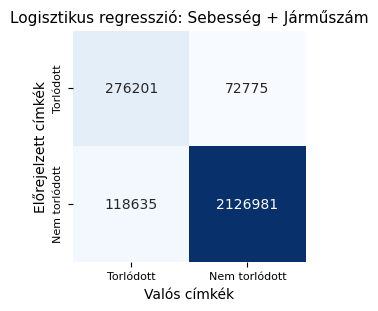

In [422]:
draw_confusionMatrix(Split_without_noise[3], regression_binary_noise_prediction, "Logisztikus regresszió: Sebesség + Járműszám", True)

#### Only Mean speed used as feature

In [322]:
regression_speed = LogisticRegression()
regression_speed.fit(Split_speed[0], Split_speed[2])

LogisticRegression()

In [323]:
Regression_speed_pred = regression_speed.predict(Split_speed[1])

In [324]:
print(classification_report(Split_speed[3], Regression_speed_pred))

               precision    recall  f1-score   support

    Congested       0.71      0.74      0.73    394836
Not congested       0.95      0.95      0.95   2199756

     accuracy                           0.92   2594592
    macro avg       0.83      0.84      0.84   2594592
 weighted avg       0.92      0.92      0.92   2594592



In [325]:
print("F-1 Score:", f1_score(Split_speed[3], Regression_speed_pred, average='macro'))

F-1 Score: 0.8390900764792109


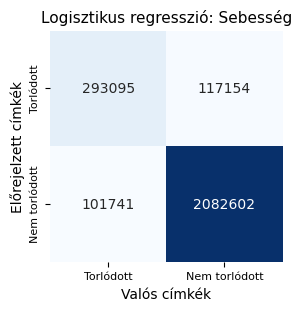

In [423]:
draw_confusionMatrix(Split_speed[3].values, Regression_speed_pred, "Logisztikus regresszió: Sebesség", True)

# Support Vector Machine

#### All features (Mean speed + Vehicle count + noise)

In [337]:
standar_scaler = StandardScaler()
Standard_trainX = standar_scaler.fit_transform(Split_all[0])
Standard_trainy = standar_scaler.transform(Split_all[1])

In [338]:
LinearSVC_all = LinearSVC()
LinearSVC_all.fit(Standard_trainX,Split_all[2].values)

LinearSVC()

In [339]:
SVC_all_pred = LinearSVC_all.predict(Standard_trainy)

In [340]:
print(classification_report(Split_all[3].values, SVC_all_pred))

               precision    recall  f1-score   support

    Congested       0.73      0.78      0.75    394836
Not congested       0.96      0.95      0.95   2199756

     accuracy                           0.92   2594592
    macro avg       0.85      0.86      0.85   2594592
 weighted avg       0.93      0.92      0.92   2594592



In [341]:
print("F-1 Score:", f1_score(Split_all[3], SVC_all_pred, average='macro'))

F-1 Score: 0.854181747536467


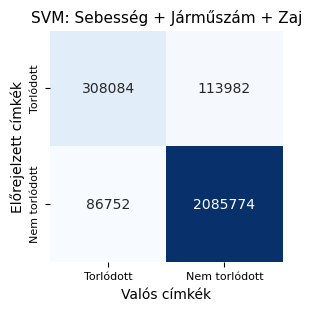

In [424]:
draw_confusionMatrix(Split_all[3], SVC_all_pred, "SVM: Sebesség + Járműszám + Zaj", True)

#### Vehicle count + Mean speed (without noise)

In [345]:
scaler_noise = StandardScaler()
Standard_noise_trainX = scaler_noise.fit_transform(Split_without_noise[0])
Standard_noise_trainy = scaler_noise.transform(Split_without_noise[1])

In [346]:
LinearSVC_noise = LinearSVC()
LinearSVC_noise.fit(Standard_noise_trainX, Split_without_noise[2].values)

LinearSVC()

In [347]:
SVC_noise_pred = LinearSVC_noise.predict(Standard_noise_trainy)

In [348]:
print(classification_report(Split_without_noise[3].values, SVC_noise_pred))

               precision    recall  f1-score   support

    Congested       0.82      0.61      0.70    394836
Not congested       0.93      0.98      0.95   2199756

     accuracy                           0.92   2594592
    macro avg       0.88      0.79      0.83   2594592
 weighted avg       0.92      0.92      0.92   2594592



In [349]:
print("F-1 Score:", f1_score(Split_without_noise[3], SVC_noise_pred, average='macro'))

F-1 Score: 0.8259856008373515


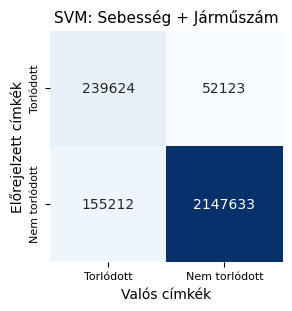

In [425]:
draw_confusionMatrix(Split_without_noise[3], SVC_noise_pred, "SVM: Sebesség + Járműszám", True)

#### Only Mean speed used as feature

In [351]:
scaler_speed = StandardScaler()
Standard_speed_trainX = scaler_speed.fit_transform(Split_speed[0])
Standard_speed_trainy = scaler_speed.transform(Split_speed[1])

In [352]:
LinearSVC_speed = LinearSVC()
LinearSVC_speed.fit(Standard_speed_trainX,Split_speed[2].values)

LinearSVC()

In [353]:
SVC_speed_pred = LinearSVC_speed.predict(Standard_speed_trainy)

In [354]:
print(classification_report(Split_speed[3].values, SVC_speed_pred))

               precision    recall  f1-score   support

    Congested       0.72      0.74      0.73    394836
Not congested       0.95      0.95      0.95   2199756

     accuracy                           0.92   2594592
    macro avg       0.83      0.84      0.84   2594592
 weighted avg       0.92      0.92      0.92   2594592



In [355]:
print("F-1 Score:", f1_score(Split_speed[3], SVC_speed_pred, average='macro'))

F-1 Score: 0.8381166173976686


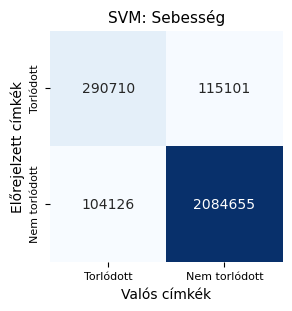

In [426]:
draw_confusionMatrix(Split_speed[3], SVC_speed_pred, "SVM: Sebesség", True, True)

# XGBoost

#### All features (Mean speed + Vehicle count + noise)

In [436]:
train_flag = Split_all[2].copy(deep=True)
train_flag = train_flag.map({'Not congested': 0, 'Congested': 1})

In [437]:
model = XGBClassifier(objective="binary:logistic")

In [438]:
model.fit(Split_all[0], train_flag)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [439]:
xgB_all_pred = model.predict(Split_all[1])

In [440]:
xgB_all_pred = pd.Series(xgB_all_pred)

In [441]:
xgB_all_pred = xgB_all_pred.map({0: 'Not congested', 1: 'Congested'})

In [442]:
print(classification_report(Split_all[3], xgB_all_pred))

               precision    recall  f1-score   support

    Congested       0.84      0.71      0.77    394836
Not congested       0.95      0.98      0.96   2199756

     accuracy                           0.93   2594592
    macro avg       0.89      0.84      0.86   2594592
 weighted avg       0.93      0.93      0.93   2594592



In [443]:
print("F-1 Score:", f1_score(Split_all[3], xgB_all_pred, average='macro'))

F-1 Score: 0.8649494246737719


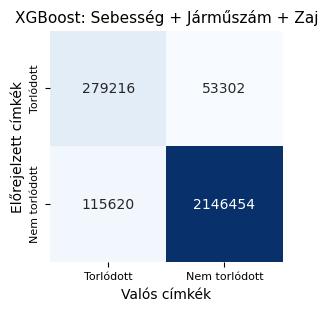

In [444]:
draw_confusionMatrix(Split_all[3], xgB_all_pred, "XGBoost: Sebesség + Járműszám + Zaj", True)

#### Vehicle count + mean speed (without noise)

In [374]:
train_flag_noise = Split_without_noise[2].copy(deep=True)
train_flag_noise = train_flag_noise.map({'Not congested': 0, 'Congested': 1})

In [375]:
xgb_noise_model = XGBClassifier(objective="binary:logistic")

In [376]:
xgb_noise_model.fit(Split_without_noise[0], train_flag_noise)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [377]:
xgB_noise_pred = xgb_noise_model.predict(Split_without_noise[1])

In [378]:
xgB_noise_pred = pd.Series(xgB_noise_pred)
xgB_noise_pred = xgB_noise_pred.map({0: 'Not congested', 1: 'Congested'})

In [379]:
print(classification_report(Split_without_noise[3], xgB_noise_pred))

               precision    recall  f1-score   support

    Congested       0.83      0.69      0.76    394836
Not congested       0.95      0.98      0.96   2199756

     accuracy                           0.93   2594592
    macro avg       0.89      0.83      0.86   2594592
 weighted avg       0.93      0.93      0.93   2594592



In [380]:
print("F-1 Score:", f1_score(Split_without_noise[3], xgB_noise_pred, average='macro'))

F-1 Score: 0.8580053351583077


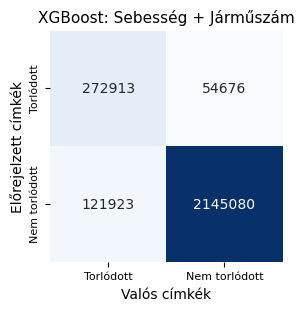

In [445]:
draw_confusionMatrix(Split_without_noise[3], xgB_noise_pred, "XGBoost: Sebesség + Járműszám", True)

#### Only Mean speed used as feature

In [382]:
train_flag_speed = Split_speed[2].copy(deep=True)
train_flag_speed = train_flag_speed.map({'Not congested': 0, 'Congested': 1})

In [383]:
xgb_speed_model = XGBClassifier(objective="binary:logistic")

In [384]:
xgb_speed_model.fit(Split_speed[0], train_flag_speed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [385]:
xgB_speed_pred = xgb_speed_model.predict(Split_speed[1])

In [386]:
xgB_speed_pred = pd.Series(xgB_speed_pred)
xgB_speed_pred = xgB_speed_pred.map({0: 'Not congested', 1: 'Congested'})

In [387]:
print(classification_report(Split_speed[3], xgB_speed_pred))

               precision    recall  f1-score   support

    Congested       0.71      0.76      0.74    394836
Not congested       0.96      0.95      0.95   2199756

     accuracy                           0.92   2594592
    macro avg       0.84      0.85      0.84   2594592
 weighted avg       0.92      0.92      0.92   2594592



In [388]:
print("F-1 Score:", f1_score(Split_speed[3], xgB_speed_pred, average='macro'))

F-1 Score: 0.8437432032518112


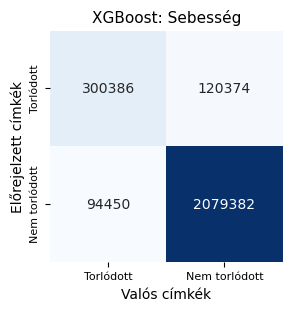

In [446]:
draw_confusionMatrix(Split_speed[3], xgB_speed_pred, "XGBoost: Sebesség", True)